In [22]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [23]:


SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Data
All data collected is from ERA5 Reanalysis through the Climate Data Store (CDS)

In [24]:
T = []
S = []
H = []
Hsw = []
Hlw = []
Hswcs = []
Hlwcs = []
for i in range(3):
    T.append(xr.open_dataset('ERA5/T'+str(90-10*i))['t'])
    S.append(xr.open_dataset('ERA5/Sol'+str(90-10*i))['tisr'])
    H.append(xr.open_dataset('ERA5/htr_inp'+str(90-10*i)+'.nc')['avg_ttpm']*86400)
    Hsw.append(xr.open_dataset('ERA5/htrsw_inp'+str(90-10*i)+'.nc')['avg_ttswr']*86400)
    Hlw.append(xr.open_dataset('ERA5/htrlw_inp'+str(90-10*i)+'.nc')['avg_ttlwr']*86400)
    Hswcs.append(xr.open_dataset('ERA5/htrswcs_inp'+str(90-10*i)+'.nc')['avg_ttswrcs']*86400)
    Hlwcs.append(xr.open_dataset('ERA5/htrlwcs_inp'+str(90-10*i)+'.nc')['avg_ttlwrcs']*86400)

## Mean Seasonal Cycle

$$S(m) = \dfrac{1}{n_y}\sum_{j=1}^{n_y}X(j,m)$$
gives the mean seasonal cycle - where $m$ is the month index, $j$ runs over all the year indices $1$ to $n_y$, and $X$ is the time series data evaluated at each month of each year.

## Long-term trend (Linear)

$$T(X'(t)) = a+bt$$

where $X'(t) = X(t) - S(m(t))$. This retrieves a long term trend of the time series data. This is done by linearly regressing the time series with time.

## Interannual Variability

This is merely the residual, given by $$I(t) = X(t) - S(m(t)) - T(X'(t))$$

In [25]:
def time_to_fractional_years(time_coord):
    """
    Converts xarray datetime coordinate to fractional years since the start.
    """
    time = pd.to_datetime(time_coord.values)
    t0 = time[0]
    return ((time - t0) / pd.Timedelta(days=365.25)).values

def fit_linear_trend(y, time_num):
    """
    Fit linear trend y = a + b * t for a 1D time series y.
    Returns fitted values along time.
    """
    mask = np.isfinite(y)
    if np.sum(mask) < 2:
        return np.full_like(time_num, np.nan)
    slope, intercept = np.polyfit(time_num[mask], y[mask], 1)
    return slope * time_num + intercept

def decompose_climate_timeseries(da):
    """
    Decomposes a climate time series into:
      - Seasonal cycle
      - Linear long-term trend
      - Interannual variability (residual)
    
    Parameters:
        da (xarray.DataArray): Must have 'time' as a dimension with monthly resolution.

    Returns:
        dict of xarray.DataArrays:
            {
                'seasonal_cycle': monthly climatology aligned with time,
                'trend': linear trend over time,
                'interannual': residual
            }
    """
    # Ensure time is sorted and continuous
    da = da.sortby('time')

    # 1. Compute seasonal climatology
    seasonal_clim = da.groupby('time.month').mean('time')
    month_of_time = da['time'].dt.month
    seasonal_aligned = seasonal_clim.sel(month=month_of_time)

    # 2. Deseasonalize
    deseasonalized = da - seasonal_aligned

    # 3. Get time as fractional years
    time_num = time_to_fractional_years(da['time'])
    time_da = xr.DataArray(time_num, dims='time', coords={'time': da['time']})

    # 4. Apply linear regression over time dimension
    trend = xr.apply_ufunc(
        fit_linear_trend,
        deseasonalized,
        time_da,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float],
    )

    # 5. Compute interannual residual
    interannual = deseasonalized - trend

    return {
        'seasonal_cycle': seasonal_aligned,
        'trend': trend,
        'interannual': interannual
    }


In [26]:
T_decompose = []
H_decompose = []
Hlw_decompose = []
Hsw_decompose = []
Hlwcs_decompose = []
Hswcs_decompose = []
Hrad_decompose = []
Hradcs_decompose = []
for i in range(3):
    T_decompose.append(decompose_climate_timeseries(T[i]))
    H_decompose.append(decompose_climate_timeseries(H[i]))
    Hlw_decompose.append(decompose_climate_timeseries(Hlw[i]))
    Hsw_decompose.append(decompose_climate_timeseries(Hsw[i]))
    Hlwcs_decompose.append(decompose_climate_timeseries(Hlwcs[i]))
    Hswcs_decompose.append(decompose_climate_timeseries(Hswcs[i]))
    Hrad_decompose.append(decompose_climate_timeseries(Hsw[i]+Hlw[i]))
    Hradcs_decompose.append(decompose_climate_timeseries(Hswcs[i]+Hlwcs[i]))


In [41]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Temperature decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(T_decompose[i]['seasonal_cycle']['time'], T_decompose[i]['seasonal_cycle']['level'], T_decompose[i]['seasonal_cycle'].transpose('level', 'time'), cmap='Reds', levels = 10)
    cs2 = ax[i%3, i//3].contour(T_decompose[i]['seasonal_cycle']['time'], T_decompose[i]['seasonal_cycle']['level'], T_decompose[i]['seasonal_cycle'].transpose('level', 'time'), levels=[233.15, 273.15], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Temperature (K)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(T_decompose[i-3]['trend']['time'], T_decompose[i-3]['trend']['level'], T_decompose[i-3]['trend'], cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Temperature (K)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(T_decompose[i-6]['interannual']['time'], T_decompose[i-6]['interannual']['level'], T_decompose[i-6]['interannual'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Temperature (K)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/T_decomposition.png', bbox_inches='tight')
plt.close()

In [28]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Diabatic Heating Rate decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], H_decompose[i]['seasonal_cycle'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    cs2 = ax[i%3, i//3].contour(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], H_decompose[i]['seasonal_cycle'].transpose('level', 'time'), levels=[0], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(H_decompose[i-3]['trend']['time'], H_decompose[i-3]['trend']['level'], H_decompose[i-3]['trend'], cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(H_decompose[i-6]['interannual']['time'], H_decompose[i-6]['interannual']['level'], H_decompose[i-6]['interannual'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/DiabHeat_decomposition.png', bbox_inches='tight')
plt.close()

In [29]:
H_og = np.empty(3, dtype=object)
month = [31,28,31,30,31,30,31,31,30,31,30,31]
for i in range(3):
    H_net = {'seasonal_cycle':0, 'trend':0,'interannual':0}
    for j in H_net.keys():
        row = []
        if j=='trend':
            for k in range(len(T_decompose[i][j][:,:120].T)):
                value = (T_decompose[i][j].T[k+1]-T_decompose[i][j].T[k])/month[k%12]
                row.append(value)    
        else: 
            for k in range(len(T_decompose[i][j][:120])):
                value = (T_decompose[i][j][k+1]-T_decompose[i][j][k])/month[k%12]
                row.append(value)
        H_net[j] = row
    H_og[i]=H_net     

In [30]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Net Heating Rate decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], np.array(H_og[i]['seasonal_cycle']).T, cmap='RdBu_r', levels = 10)
    cs2 = ax[i%3, i//3].contour(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], np.array(H_og[i]['seasonal_cycle']).T, levels=[0], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(H_decompose[i-3]['trend']['time'], H_decompose[i-3]['trend']['level'], np.array(H_og[i-3]['trend']).T, cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(H_decompose[i-6]['interannual']['time'], H_decompose[i-6]['interannual']['level'], np.array(H_og[i-6]['interannual']).T, cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/NetHeat_decomposition.png', bbox_inches='tight')
plt.close()

In [31]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Dynamic Heating Rate decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], np.array(H_og[i]['seasonal_cycle']).T-H_decompose[i]['seasonal_cycle'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    cs2 = ax[i%3, i//3].contour(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], np.array(H_og[i]['seasonal_cycle']).T-H_decompose[i]['seasonal_cycle'].transpose('level', 'time'), levels=[0], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(H_decompose[i-3]['trend']['time'], H_decompose[i-3]['trend']['level'], np.array(H_og[i-3]['trend']).T-H_decompose[i-3]['trend'], cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(H_decompose[i-6]['interannual']['time'], H_decompose[i-6]['interannual']['level'], np.array(H_og[i-6]['interannual']).T-H_decompose[i-6]['interannual'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/DynHeat_decomposition.png', bbox_inches='tight')
plt.close()

In [32]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Net Radiative Heating Rate decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], Hrad_decompose[i]['seasonal_cycle'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    cs2 = ax[i%3, i//3].contour(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], Hrad_decompose[i]['seasonal_cycle'].transpose('level', 'time'), levels=[0], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(H_decompose[i-3]['trend']['time'], H_decompose[i-3]['trend']['level'], Hrad_decompose[i-3]['trend'], cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(H_decompose[i-6]['interannual']['time'], H_decompose[i-6]['interannual']['level'], Hrad_decompose[i-6]['interannual'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/RadHeat_decomposition.png', bbox_inches='tight')
plt.close()

In [33]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Net Clear Sky Radiative Heating Rate decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], Hradcs_decompose[i]['seasonal_cycle'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    cs2 = ax[i%3, i//3].contour(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], Hradcs_decompose[i]['seasonal_cycle'].transpose('level', 'time'), levels=[0], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(H_decompose[i-3]['trend']['time'], H_decompose[i-3]['trend']['level'], Hradcs_decompose[i-3]['trend'], cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(H_decompose[i-6]['interannual']['time'], H_decompose[i-6]['interannual']['level'], Hradcs_decompose[i-6]['interannual'].transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/CSRadHeat_decomposition.png', bbox_inches='tight')
plt.close()

In [34]:
fig, ax =  plt.subplots(3, 3, figsize=(40,20))
fig.suptitle('Arctic Net Cloud Heating Rate decomposition', x=0.48)
fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
fig.text(0.49, 0.93, 'Linear Trend', ha='center', fontsize=16)
fig.text(0.76, 0.93, 'Interannual', ha='center', fontsize=16)
for i in range(3):
    cs = ax[i%3, i//3].contourf(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], (Hrad_decompose[i]['seasonal_cycle']-Hradcs_decompose[i]['seasonal_cycle']).transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    cs2 = ax[i%3, i//3].contour(H_decompose[i]['seasonal_cycle']['time'], H_decompose[i]['seasonal_cycle']['level'], (Hrad_decompose[i]['seasonal_cycle']-Hradcs_decompose[i]['seasonal_cycle']).transpose('level', 'time'), levels=[0], colors='black', linewidths=1.5)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].clabel(cs2)
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_mean_seasonal.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Linear Trend', x=0.60)
for i in range(3,6):
    cs = ax[i%3, i//3].contourf(H_decompose[i-3]['trend']['time'], H_decompose[i-3]['trend']['level'], (Hrad_decompose[i-3]['trend']-Hradcs_decompose[i-3]['trend']), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
# fig.savefig('Plots_ERA5/Variation_plots/Htr_trend_lin.png', bbox_inches='tight')

# fig, ax =  plt.subplots(3, 1, figsize=(25,12))
# fig.suptitle('Interannual Variation', x=0.90)
for i in range(6,9):
    cs = ax[i%3, i//3].contourf(H_decompose[i-6]['interannual']['time'], H_decompose[i-6]['interannual']['level'], (Hrad_decompose[i-6]['interannual']-Hradcs_decompose[i-6]['interannual']).transpose('level', 'time'), cmap='RdBu_r', levels = 10)
    ax[i%3, i//3].set_yscale('log')
    ax[i%3, i//3].set_xlabel('Year')
    ax[i%3, i//3].set_ylabel('Altitude (hPa)')
    ax[i%3, i//3].set_title(r''+str(90-10*(i-6))+'-'+str(80-10*(i-6))+'$^{\circ}$ N')
    fig.colorbar(cs, label='Heating Rate (K/day)', ax=ax[i%3, i//3])
    ax[i%3, i//3].invert_yaxis()
    
# plt.tight_layout()
fig.savefig('Plots_ERA5/Variation_plots/CloudHeat_decomposition.png', bbox_inches='tight')
plt.close()

## Solar insolation and Temperature response

In [35]:
lev = 1000
fig, ax =  plt.subplots(3,2, figsize=(30, 12))
fig.suptitle('Zonal and Diurnal mean of TOA irradiance and Diabatic Heating Rate', x=0.5)
for i in range(3):
    temp = S[i][:120]
    ax2 = ax[i%3, i//3].twinx()
    ax[i%3, i//3].plot(H[i]['time'], Hsw[i].sel(level=lev), label='Response', color='red')
    ax2.plot(temp['time'], temp/3600, color='blue')
    ax[i%3, i//3].set_xlabel('Day')
    ax[i%3, i//3].set_ylabel('SW htr,'+str(lev)+' hPa (K/day)')
    ax2.set_ylabel('Solar insolation (W/$m^2$)')
    # plt.xticks(np.arange(1,12,1))
    ax[i%3, i//3].set_title(''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    ax[i%3, i//3].legend()
for i in range(3,6):
    ax2 = ax[i%3, i//3].twinx()
    ax[i%3, i//3].plot(H[i-3]['time'], Hlw[i-3].sel(level=lev), label='Response', color='red')
    ax2.plot(temp['time'], temp/3600, color='blue')
    ax[i%3, i//3].set_xlabel('Day')
    ax[i%3, i//3].set_ylabel('LW htr,'+str(lev)+' hPa (K/day)')
    ax2.set_ylabel('Solar insolation (W/$m^2$)')
    # plt.xticks(np.arange(1,12,1))
    ax[i%3, i//3].set_title(''+str(90-10*(i-3))+'-'+str(80-10*(i-3))+'$^{\circ}$ N')
    ax[i%3, i//3].legend()
plt.tight_layout()
fig.savefig('Plots_ERA5/radhtr'+str(lev)+'.png')
plt.close()

In [36]:
def compute_lagged_correlation(insolation, temperature, max_lag=6):
    """
    Compute lagged correlation between insolation and temperature.
    Parameters:
        insolation (xr.DataArray): 1D time series
        temperature (xr.DataArray): 1D time series (same time length as insolation)
        max_lag (int): maximum months to shift forwards and backwards
    Returns:
        lags (list): list of lag values
        correlations (list): correlation at each lag
    """
    assert insolation.shape[0] == temperature.shape[0], "Time dimensions must match"

    lags = range(-max_lag, max_lag + 1)
    correlations = []

    # Standardize
    ins = (insolation - insolation.mean()) / insolation.std()
    temp = (temperature - temperature.mean()) / temperature.std()

    for lag in lags:
        if lag < 0:
            shifted_temp = temp[-lag:]
            valid_ins = ins[:lag]
        elif lag > 0:
            shifted_temp = temp[:-lag]
            valid_ins = ins[lag:]
        else:
            shifted_temp = temp
            valid_ins = ins

        corr = pearsonr(valid_ins, shifted_temp)[0]
        correlations.append(corr)

    return list(lags), correlations

def plot_lag_correlation(lags, correlations, i, name):
    plt.figure(figsize=(8, 4))
    plt.plot(lags, correlations, marker='o')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.title('Lead-Lag Correlation for '+str(90-10*i)+'$^{\circ}$ to '+str(80-10*i)+'$^{\circ}$ : '+name+' vs Solar Insolation')
    plt.xlabel('Lag (months) [negative = '+name+' lags]')
    plt.ylabel('Pearson Correlation')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Plots_ERA5/Variation_plots/'+name+str(90-10*i)+'.png', bbox_inches='tight')
    plt.close()
     
# Example usage
# Assuming `insolation` and `temperature` are loaded xarray.DataArrays
# insolation: (time,)
# temperature: (level, time)

def run_analysis(insolation: xr.DataArray, temperature: xr.DataArray, i, name):
    temp_1000 = temperature.sel(level=200, method='nearest')

    lags, corrs = compute_lagged_correlation(insolation, temp_1000)
    plot_lag_correlation(lags, corrs, i, name)

    max_corr_idx = np.argmax(corrs)
    best_lag = lags[max_corr_idx]
    print(f"Maximum correlation = {corrs[max_corr_idx]:.3f} at lag = {best_lag} months")

    return best_lag, corrs[max_corr_idx]

In [37]:
for i in range(3):
    run_analysis(S[i][1:], T[i], i, 'Temp')
for i in range(3):    
    run_analysis(S[i][:120], -Hlw[i], i, 'LWCool')
for i in range(3):
        run_analysis(S[i][:120], Hsw[i], i,'SWHeat')

Maximum correlation = 0.837 at lag = -1 months
Maximum correlation = 0.856 at lag = -1 months
Maximum correlation = 0.887 at lag = -1 months
Maximum correlation = 0.876 at lag = -1 months
Maximum correlation = 0.917 at lag = 0 months
Maximum correlation = 0.939 at lag = 0 months
Maximum correlation = 0.990 at lag = 1 months
Maximum correlation = 0.995 at lag = 1 months
Maximum correlation = 0.997 at lag = 1 months


## Finding Tropopause

In [38]:
import math

### constants###
g = 9.81 # m/s^2
r = 287 # J/kg K

def dz (T, p1, p2):
    delz = r*T/g * math.log(p1/p2) #hypsometric equation
    return delz

def trop_routine(delz):
    if delz >=2000:
        return 1
    else:
        return 0

def return_tropopause(dat):
    index = 0
    data = dat.copy()
    data = data.reindex(level=data.level[::-1])
    l_atm = len(data['level'])
    for i in range(4,l_atm-1):
        mean_T = (data[i]+data[i+1])/2
        dTdz_init = 1000*(data[i+1].data-data[i].data)/dz(mean_T, data['level'].data[i], data['level'].data[i+1]).data
        if -dTdz_init <=2:

            for j in range(i+1, l_atm):
                mean_T = (data[i]+data[j])/2
                delz= dz(mean_T, data['level'].data[i], data['level'].data[j]).data
                flag = trop_routine(delz)
                if flag == 1:
                    break

            dTdz = 1000*(data[j].data-data[i].data)/delz
            #print(-dTdz, delz, i, j)
            if -dTdz <= 2:
                index = i
                break
    return data['level'][i]

def trop_time(data):
    parr = []
    for i in range(len(data['time'])):
        parr.append(return_tropopause(data.isel(time=i)))
    return parr, data['time']

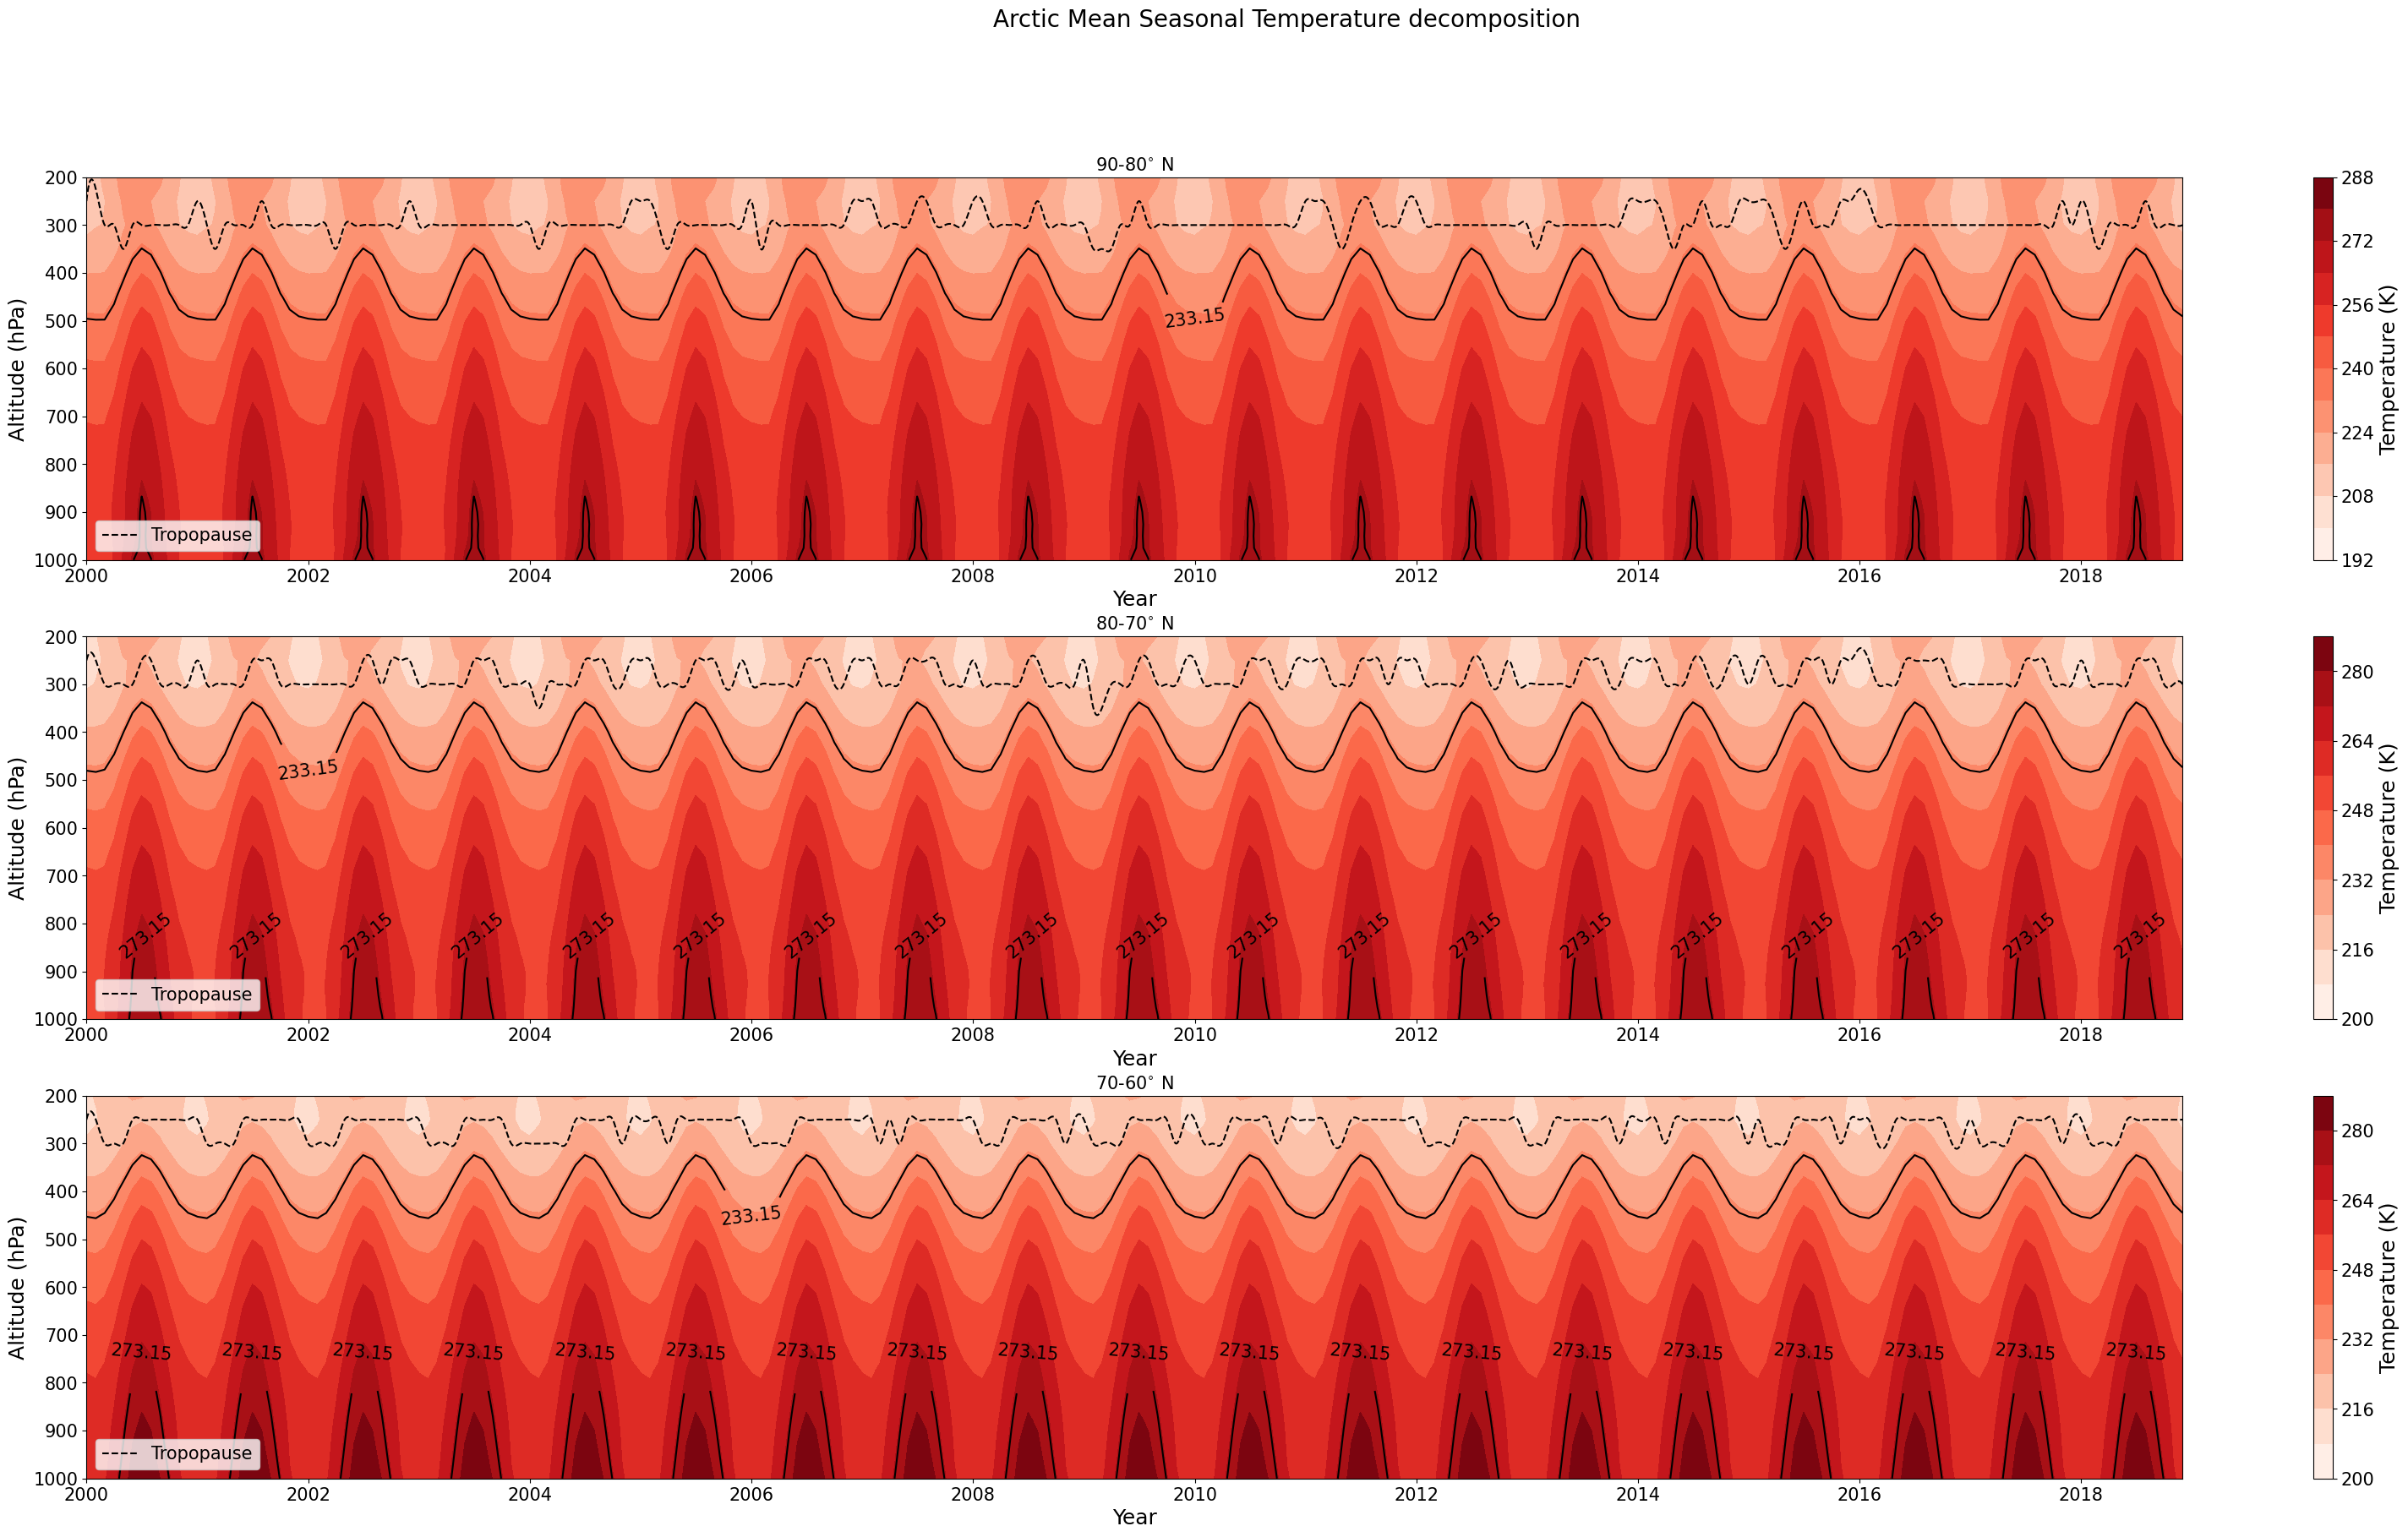

In [42]:
from scipy.interpolate import make_interp_spline, BSpline
fig, ax =  plt.subplots(3, 1, figsize=(40,20))
fig.suptitle('Arctic Mean Seasonal Temperature decomposition', x=0.48)
# fig.text(0.22, 0.93, 'Mean Seasonal', ha='center', fontsize=16)
for i in range(3):
    p, time = trop_time(T[i])
    # 300 represents number of points to make between T.min and T.max
    xnew = pd.date_range(start='2000-01-01', end='2018-12-01',periods=5000)
    spl = make_interp_spline(time, p, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    cs = ax[i%3].contourf(T_decompose[i]['seasonal_cycle']['time'], T_decompose[i]['seasonal_cycle']['level'], T_decompose[i]['seasonal_cycle'].transpose('level', 'time'), cmap='Reds', levels = 10)
    cs2 = ax[i%3].contour(T_decompose[i]['seasonal_cycle']['time'], T_decompose[i]['seasonal_cycle']['level'], T_decompose[i]['seasonal_cycle'].transpose('level', 'time'), levels=[233.15, 273.15], colors='black', linewidths=1.5)
    ax[i%3].plot(xnew, power_smooth, label='Tropopause', color='black', linewidth=1.5, linestyle = '--')
    # ax[i%3].set_yscale('log')
    ax[i%3].set_xlabel('Year')
    ax[i%3].set_ylabel('Altitude (hPa)')
    ax[i%3].set_title(r''+str(90-10*i)+'-'+str(80-10*i)+'$^{\circ}$ N')
    fig.colorbar(cs, label='Temperature (K)', ax=ax[i%3])
    ax[i%3].clabel(cs2)
    ax[i%3].set_ylim(200,1000)
    ax[i%3].invert_yaxis()
    ax[i%3].legend()
fig.savefig('Plots_ERA5/Variation_plots/T_decomposition_tropopause.png', bbox_inches='tight')
